# Data cleaning
Load the data and clean it using the BDT

In [2]:
import joblib
import uproot
import boost_histogram as bh
import matplotlib.pyplot as plt
import awkward as ak
import pickle
import numpy as np

In [3]:
def get_config(is_jaguar=True):
    """
        histograms_path = Set the path to store the histograms
        model_path = Set the path to load the BDT to clean the data
        response_matrix_path = Set the path to read the response matrix
    """
    # histograms configuration
    config = {
        "hist" : {
            "nbins" : 50,
            "rmin" : 0.2,
            "rmax" : 1.8
        }
    }
    if is_jaguar:
        print("Loading configuration to run in Jaguar")
        config["data"] = {
            "files" : "/storage/cpegueros/tau2pipi0_taupair_1623721564_00/sub00/data40/*.root",
            "workers" : 45,
            "step_size" : "500 MB"
        }
        config["model_path"] = "/home/cpegueros/bdt/gradient_1626485324.joblib"
        config["histograms_path"] = "/home/cpegueros/thesis/tau2pipi0nu_data_to_unfold.pkl"
        config["response_matrix_path"] = "/home/cpegueros/thesis/tau2pipi0nu_response_matrix.pkl"
    else:
        print("Loading configuration to run in local. No data will be available.")
        config["data"] = {
            "files" : None,
            "workers" : None,
            "step_size" : None
        }
        config["model_path"] = "/home/peguerosdc/development/thesis/data/gradient_1626485324.joblib"
        config["histograms_path"] = "/home/peguerosdc/development/thesis/data/tau2pipi0nu_data_to_unfold.pkl"
        config["response_matrix_path"] = "/home/peguerosdc/development/thesis/data/tau2pipi0nu_response_matrix.pkl"
    return config

In [3]:
config = get_config(is_jaguar=True)

Loading configuration to run in Jaguar


In [7]:
# Amount of bins and histogram limits
nbins, rmin, rmax = config["hist"]["nbins"], config["hist"]["rmin"], config["hist"]["rmax"]

# Histogram to store the data
data_raw_invM = bh.Histogram(bh.axis.Regular(nbins, rmin, rmax))
data_invM = bh.Histogram(bh.axis.Regular(nbins, rmin, rmax))
data_invM_mc = bh.Histogram(bh.axis.Regular(nbins, rmin, rmax))
# to test how good is the BDT
after_bdt_signal = bh.Histogram(bh.axis.Regular(nbins, rmin, rmax))
after_bdt_bg = bh.Histogram(bh.axis.Regular(nbins, rmin, rmax))

In [8]:
# load the BDT
bdt = joblib.load(config["model_path"])

# variables to load from the data
branches_to_train = ["thrust","visibleEnergyOfEventCMS","track_sig_EoverP","track_sig_pionID","track_sig_pt", "sig_gamma1_E","sig_gamma2_E","track_sig_cosToThrustOfEvent","neutral_sig_E","neutral_sig_M"]
branches_to_cut = ["nPi0s_sig"]
branch_of_interest = ["tau_sig_InvM", "tau_sig_matchedMC_InvM"]
branches_mc = ["track_sig_charge", "tauPlusMCMode", "tauMinusMCMode"]
branches_to_load = branches_to_train + branches_to_cut + branch_of_interest + branches_mc

for df in uproot.iterate(f"{config['data']['files']}:tau1x1", filter_name=branches_to_load, step_size=config["data"]["step_size"], num_workers=config["data"]["workers"]):
    # filter events with one pi0
    one_pi0 = df[ (df.nPi0s_sig == 1) ]
    one_pi0_pd = ak.to_pandas(one_pi0)
    # convert to pandas and apply the BDT
    data_to_clean = one_pi0_pd[branches_to_train]
    data_to_clean_mass = one_pi0.tau_sig_InvM
    data_to_clean_mass_truth = one_pi0.tau_sig_matchedMC_InvM
    label = bdt.predict(data_to_clean)
    data_clean, data_clean_mass, data_to_clean_mass_truth = data_to_clean[(label==1)], data_to_clean_mass[(label==1)], data_to_clean_mass_truth[(label==1)]
    # build histograms
    data_raw_invM.fill(data_to_clean_mass)
    data_invM.fill(data_clean_mass)
    data_invM_mc.fill(data_to_clean_mass_truth)
    # check how good is the BDT
    data_to_clean_with_mc = one_pi0_pd[branches_to_train + branches_mc + branch_of_interest]
    data_clean_with_mc = data_to_clean_with_mc[(label==1)]
    signal_after_bdt = data_clean_with_mc[( ( 
        ( (data_clean_with_mc.track_sig_charge==1)  & (data_clean_with_mc.tauPlusMCMode ==4) ) | 
        ( (data_clean_with_mc.track_sig_charge==-1) & (data_clean_with_mc.tauMinusMCMode==4) )
    ) == 1 )]
    after_bdt_signal.fill(signal_after_bdt.tau_sig_matchedMC_InvM)
    bg_after_bdt = data_clean_with_mc[( ( 
        ( (data_clean_with_mc.track_sig_charge==1)  & (data_clean_with_mc.tauPlusMCMode ==4) ) | 
        ( (data_clean_with_mc.track_sig_charge==-1) & (data_clean_with_mc.tauMinusMCMode==4) )
    ) == 0 )]
    after_bdt_bg.fill(bg_after_bdt.tau_sig_matchedMC_InvM)


# Save a tuple containing these two histograms in a Pickle file
with open(config["histograms_path"], 'wb') as output:
    temp = {
        "data_raw_invM" : data_raw_invM,
        "after_bdt_signal" : after_bdt_signal,
        "after_bdt_bg" : after_bdt_bg,
        "data_invM" : data_invM,
        "data_invM_mc" : data_invM_mc,
    }
    pickle.dump(temp, output)

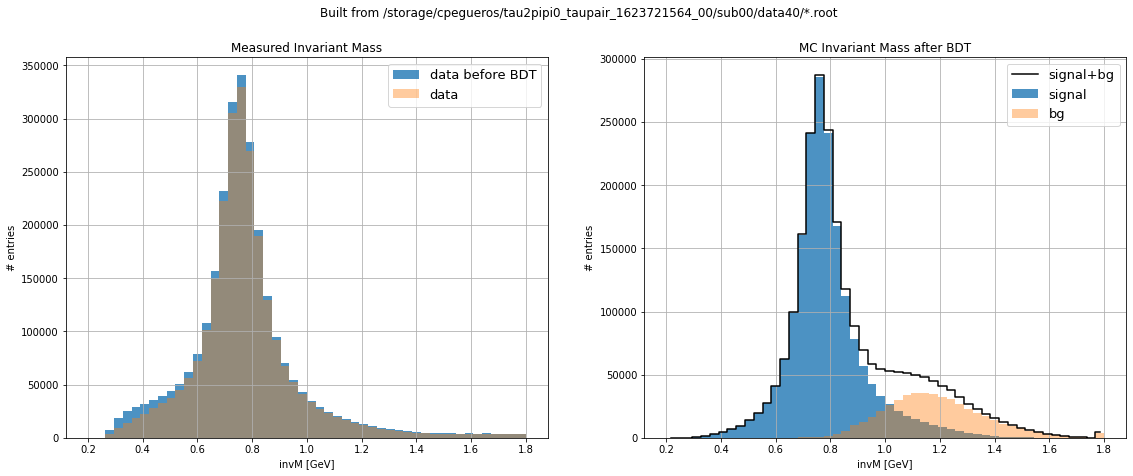

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(19, 7))
fig.suptitle(f"Built from {config['data']['files']}")

# Plot the histograms of the data before and after BDT
ax_data = axs[0]
ax_data.bar(data_raw_invM.axes[0].centers, data_raw_invM.view(), width=data_raw_invM.axes[0].widths, label="data before BDT", alpha=0.8)
ax_data.bar(data_invM.axes[0].centers, data_invM.view(), width=data_invM.axes[0].widths, label="data", alpha=0.4)
ax_data.grid()
ax_data.set_xlabel("invM [GeV]")
ax_data.set_ylabel("# entries")
ax_data.set_title("Measured Invariant Mass")
ax_data.legend(prop={"size": 13})

# Plot the histograms of how signal and bg is distributed after BDT
ax_eval = axs[1]
ax_eval.bar(after_bdt_signal.axes[0].centers, after_bdt_signal.view(), width=after_bdt_signal.axes[0].widths, label="signal", alpha=0.8)
ax_eval.bar(after_bdt_bg.axes[0].centers, after_bdt_bg.view(), width=after_bdt_bg.axes[0].widths, label="bg", alpha=0.4)
composite = after_bdt_signal + after_bdt_bg
ax_eval.step(composite.axes[0].centers, composite.view(), color="black", label="signal+bg", where="mid")
ax_eval.grid()
ax_eval.set_title("MC Invariant Mass after BDT")
ax_eval.set_xlabel("invM [GeV]")
ax_eval.set_ylabel("# entries")
ax_eval.legend(prop={"size": 13})

# Unfolding
Load the response matrix and perform the unfolding

In [4]:
# Unfolding libraries
from unfolders.unfolder import Unfolder
from utils.stats import compute_numpy_covariance_matrix
from unfolders.annealing import (
    SimulatedAnnealingBackend,
    SimulatedQuantumAnnealingBackend,
)
from unfolders.svd import SVDBackend

config = get_config(is_jaguar=False)

Loading configuration to run in local. No data will be available.


In [5]:
# First, load the histograms
with open(config["histograms_path"], 'rb') as output:
    temp = pickle.load(output)
    data_hist = temp["data_invM"]
    data_hist_mc = temp["data_invM_mc"]
    # convert to numpy array
    data_invM, data_invM_bins = data_hist.to_numpy()
    data_invM_mc, data_invM_mc_bins = data_hist_mc.to_numpy()
    statcov = compute_numpy_covariance_matrix(data_invM)
    # get signal,bg after BDT
    data_after_bdt_signal, data_after_bdt_signal_bins = temp["after_bdt_signal"].to_numpy()
    data_after_bdt_bg, data_after_bdt_bg_bins = temp["after_bdt_bg"].to_numpy()

# And load the response matrix
with open(config["response_matrix_path"], 'rb') as output:
    response_data = pickle.load(output)
    # transform histograms to numpy arrays
    truth, truth_bins = response_data["truth"].to_numpy()
    reco, reco_bins = response_data["reco"].to_numpy()
    R, R_bins_x, R_bins_y = response_data["R"].to_numpy()

In [6]:
nbins, rmin, rmax = config["hist"]["nbins"], config["hist"]["rmin"], config["hist"]["rmax"]

unfolder = Unfolder(data_invM, statcov, truth, reco, R)
# try with simulated annealing
backend = SimulatedAnnealingBackend(4, 100, weight_regularization=0.7)
annealing_result = unfolder.unfold(backend)
# try with SVD
svd_backend = SVDBackend(13, rmin, rmax)
svd_result = unfolder.unfold(svd_backend)

/home/peguerosdc/development/thesis/unfolders/annealing/backend.py:201: RuntimeWarning: invalid value encountered in true_divide
  R_probabilities = np.where(xini > 0, np.divide(R, xini), 0)


num reads: 100


Info in <TSVDUnfold::Unfold>: Unfolding param: 13
Info in <TSVDUnfold::Unfold>: Curvature of weight distribution: 0.660945


Text(0, 0.5, '# entries')

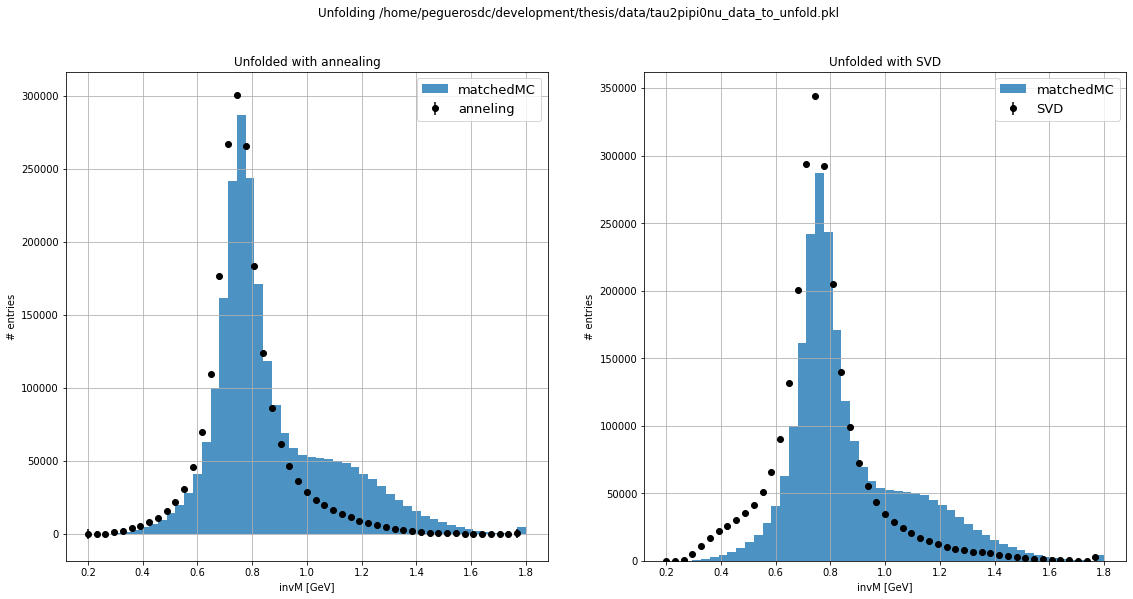

In [7]:
# Plot the result
axis = truth_bins[:-1]
fig, axs = plt.subplots(1, 2, figsize=(19, 9))
fig.suptitle(f"Unfolding {config['histograms_path']}")

# Plot the original distribution and the unfolded with annealing
axs[0].bar(data_hist_mc.axes[0].centers, data_hist_mc.view(), width=data_hist_mc.axes[0].widths, label="matchedMC", alpha=0.8)
axs[0].errorbar(
    axis,
    annealing_result.solution,
    yerr=annealing_result.error,
    fmt="o",
    color="black",
    label="anneling",
)
axs[0].legend(prop={"size": 13})
axs[0].grid()
axs[0].set_title("Unfolded with annealing")
axs[0].set_xlabel("invM [GeV]")
axs[0].set_ylabel("# entries")
# Plot the original distribution and the unfolded with SVD
axs[1].bar(data_hist_mc.axes[0].centers, data_hist_mc.view(), width=data_hist_mc.axes[0].widths, label="matchedMC", alpha=0.8)
axs[1].errorbar(
    axis,
    svd_result.solution,
    yerr=svd_result.error,
    fmt="o",
    color="black",
    label="SVD",
)
axs[1].legend(prop={"size": 13})
axs[1].grid()
axs[1].set_title("Unfolded with SVD")
axs[1].set_xlabel("invM [GeV]")
axs[1].set_ylabel("# entries")

# Unfolding signal+background
Test how the unfolding looks by unfolding the signal and the background separately

In [8]:
# try unfolding the signal and the bg
nbins, rmin, rmax = config["hist"]["nbins"], config["hist"]["rmin"], config["hist"]["rmax"]

# unfold the signal
unfolder = Unfolder(data_after_bdt_signal, compute_numpy_covariance_matrix(data_after_bdt_signal), truth, reco, R)
signal_annealing_result = unfolder.unfold(SimulatedAnnealingBackend(4, 100, weight_regularization=0.0001))
signal_svd_result = unfolder.unfold(SVDBackend(13, rmin, rmax))

# unfold the background
unfolder = Unfolder(data_after_bdt_bg, compute_numpy_covariance_matrix(data_after_bdt_bg), truth, reco, R)
bg_annealing_result = unfolder.unfold(SimulatedAnnealingBackend(4, 100, weight_regularization=0.7))
bg_svd_result = unfolder.unfold(SVDBackend(13, rmin, rmax))

/home/peguerosdc/development/thesis/unfolders/annealing/backend.py:201: RuntimeWarning: invalid value encountered in true_divide
  R_probabilities = np.where(xini > 0, np.divide(R, xini), 0)


num reads: 100
num reads: 100


Info in <TSVDUnfold::Unfold>: Unfolding param: 13
Info in <TSVDUnfold::Unfold>: Curvature of weight distribution: 0.020869
Info in <TSVDUnfold::Unfold>: Unfolding param: 13
Info in <TSVDUnfold::Unfold>: Curvature of weight distribution: 0.086242


Text(0, 0.5, '# entries')

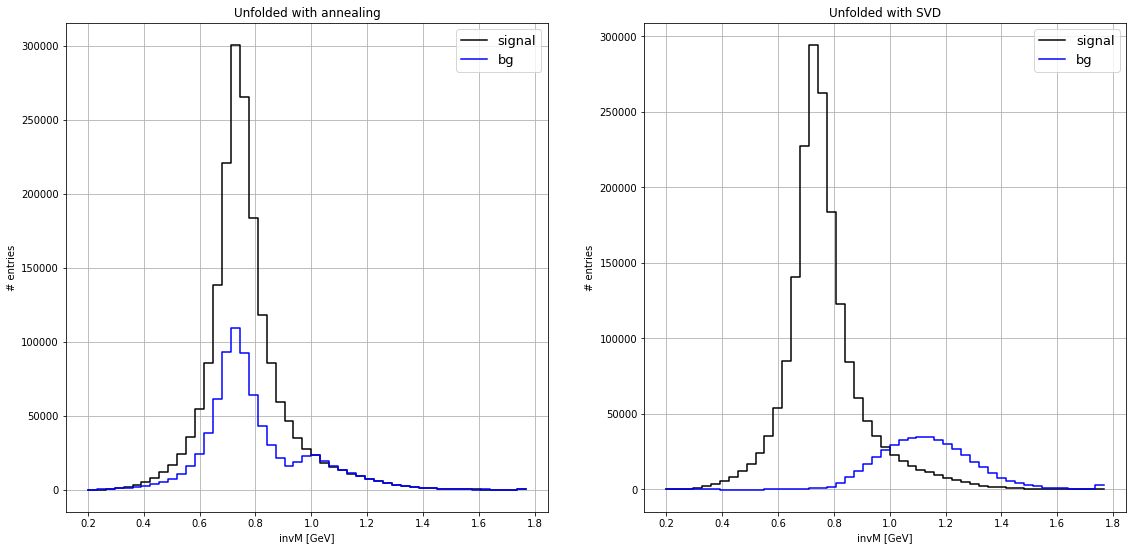

In [9]:
# Plot the result
axis = truth_bins[:-1]
fig, axs = plt.subplots(1, 2, figsize=(19, 9))
# Plot the original distribution and the unfolded with annealing
#axs[0].bar(data_hist_mc.axes[0].centers, data_hist_mc.view(), width=data_hist_mc.axes[0].widths, label="matchedMC", alpha=0.8)
axs[0].step(
    axis,
    signal_annealing_result.solution,
    color="black",
    label="signal",
)
axs[0].step(
    axis,
    bg_annealing_result.solution,
    color="blue",
    label="bg",
)
axs[0].legend(prop={"size": 13})
axs[0].grid()
axs[0].set_title("Unfolded with annealing")
axs[0].set_xlabel("invM [GeV]")
axs[0].set_ylabel("# entries")

# Plot the original distribution and the unfolded with SVD
#axs[1].bar(data_hist_mc.axes[0].centers, data_hist_mc.view(), width=data_hist_mc.axes[0].widths, label="matchedMC", alpha=0.8)
axs[1].step(
    axis,
    signal_svd_result.solution,
    color="black",
    label="signal",
)
axs[1].step(
    axis,
    bg_svd_result.solution,
    color="blue",
    label="bg",
)
axs[1].legend(prop={"size": 13})
axs[1].grid()
axs[1].set_title("Unfolded with SVD")
axs[1].set_xlabel("invM [GeV]")
axs[1].set_ylabel("# entries")